# SOAI Lab: Smart Home Energy Consumption Prediction


# INSTALL DEPENDENCIES


## Part 0 : Import used libraries

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import holidays
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Part 1 : Understand the data and Exploring it

### 1.1. Load the Training Data :
- The first step is to load the training data into the system. This is typically done using a data

In [37]:
# Load the training data
train_data = pd.read_csv('data/train_energy.csv')

### 1.2. Inspect the Training Data
- Inspect the training data to understand the distribution of the target variable and the features. This step is crucial

In [38]:
# Display the first few rows of the training data
print(train_data)

# Display information about the training data
print(train_data.info())

# Display summary statistics of the training data
print(train_data.describe())

# Check for missing values in the training data
print(train_data.isnull().sum())

                  DateTime  EnergyConsumption(kWh)
0      2015-11-01 00:00:00                      15
1      2015-11-01 01:00:00                      13
2      2015-11-01 02:00:00                      10
3      2015-11-01 03:00:00                       7
4      2015-11-01 04:00:00                       9
...                    ...                     ...
10244  2016-12-31 20:00:00                      37
10245  2016-12-31 21:00:00                      32
10246  2016-12-31 22:00:00                      33
10247  2016-12-31 23:00:00                      32
10248  2017-01-01 00:00:00                      27

[10249 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10249 entries, 0 to 10248
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   DateTime                10249 non-null  object
 1   EnergyConsumption(kWh)  10249 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 160.

### 1.3. Extracting Meaningful Informations
- Extracting temporal features form Datetime

In [39]:
# Convert DateTime to pandas datetime object
train_data['DateTime'] = pd.to_datetime(train_data['DateTime'])

In [315]:

# Extract features
train_data['hour'] = train_data['DateTime'].dt.hour
train_data['day_of_week'] = train_data['DateTime'].dt.dayofweek  # Monday=0, Sunday=6
train_data['quarter'] = train_data['DateTime'].dt.quarter
train_data['is_weekend'] = train_data['day_of_week'] >= 5
train_data['month'] = train_data['DateTime'].dt.month
train_data['year'] = train_data['DateTime'].dt.year
train_data['day_of_year'] = train_data['DateTime'].dt.dayofyear
train_data['day_of_month'] = train_data['DateTime'].dt.day
train_data['week_of_year'] = train_data['DateTime'].dt.isocalendar().week
# Holiday feature
us_holidays = holidays.US()
train_data['is_holiday'] = train_data['DateTime'].isin(us_holidays).astype(int)

### 1.4. Visualising Trends
- Visualising trends is an important aspect of data analysis. It helps to identify patterns, relationships
and anomalies in the data. There are several types of visualisations that can be used to
visualise trends

#### 1.4.1. Hourly Trends

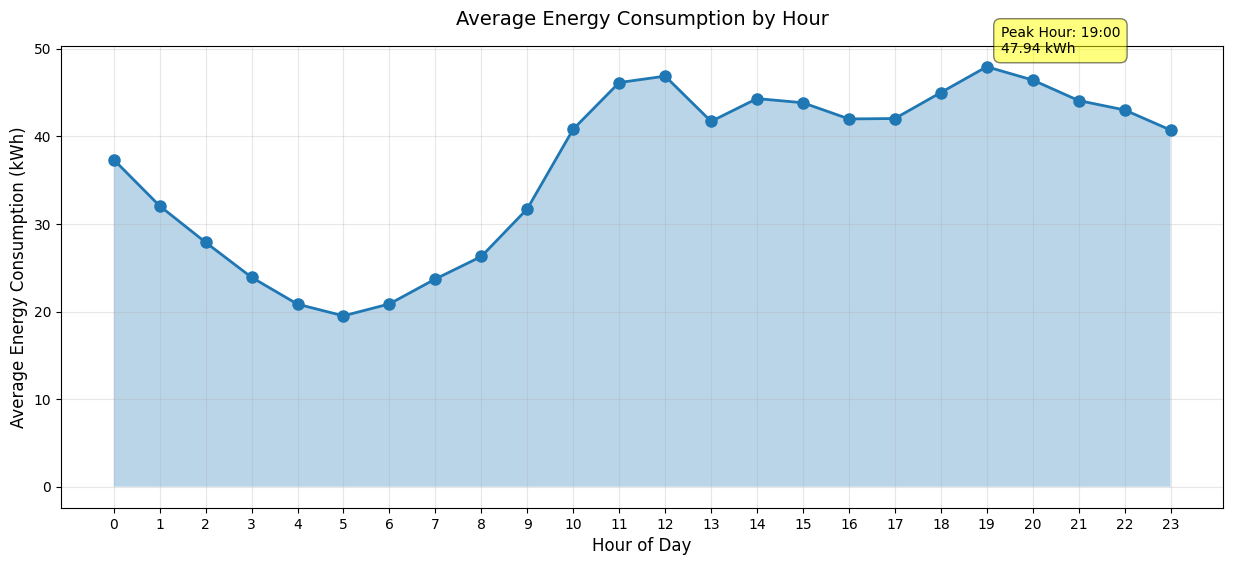

In [164]:
plt.figure(figsize=(15, 6))
hourly_avg = train_data.groupby('hour')['EnergyConsumption(kWh)'].mean()

plt.plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2, markersize=8)
plt.fill_between(hourly_avg.index, hourly_avg.values, alpha=0.3)
plt.title('Average Energy Consumption by Hour', fontsize=14, pad=15)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Average Energy Consumption (kWh)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24))

# Add peak hours annotation
peak_hour = hourly_avg.idxmax()
plt.annotate(f'Peak Hour: {peak_hour}:00\n{hourly_avg[peak_hour]:.2f} kWh', 
            xy=(peak_hour, hourly_avg[peak_hour]),
            xytext=(10, 10), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))
plt.show()

#### 1.4.2. Daily Trends

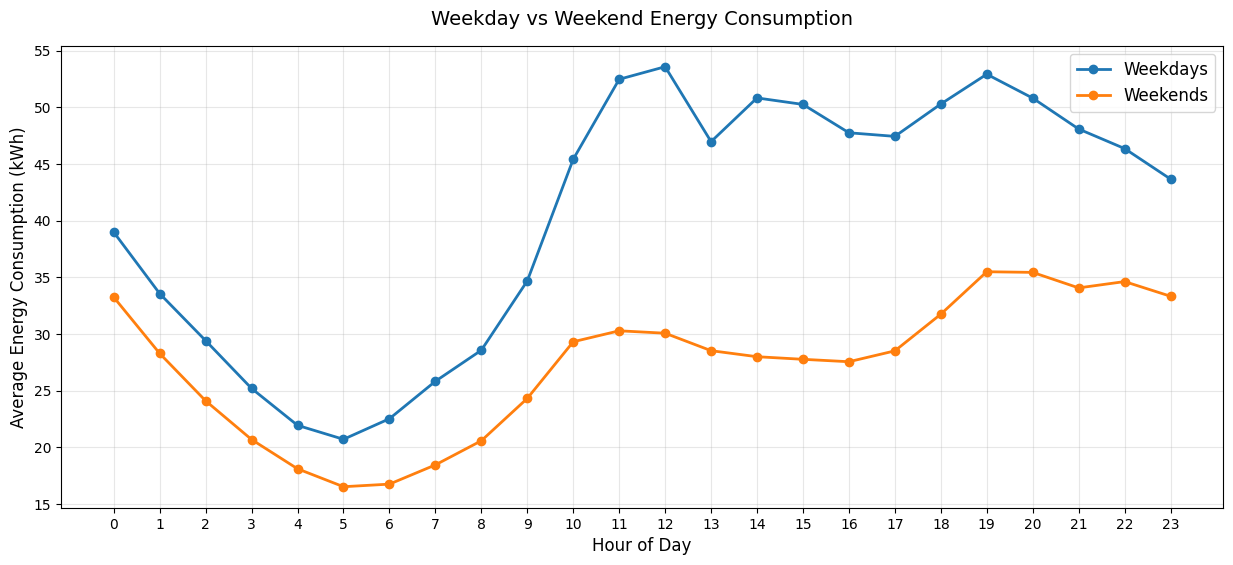

In [165]:
plt.figure(figsize=(15, 6))

# Calculate averages
weekday_hourly = train_data[~train_data['is_weekend']].groupby('hour')['EnergyConsumption(kWh)'].mean()
weekend_hourly = train_data[train_data['is_weekend']].groupby('hour')['EnergyConsumption(kWh)'].mean()

# Plot both lines
plt.plot(weekday_hourly.index, weekday_hourly.values, label='Weekdays', marker='o', linewidth=2)
plt.plot(weekend_hourly.index, weekend_hourly.values, label='Weekends', marker='o', linewidth=2)
plt.title('Weekday vs Weekend Energy Consumption', fontsize=14, pad=15)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Average Energy Consumption (kWh)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.xticks(range(0, 24))
plt.show()

#### 1.4.3. Weekly Trends

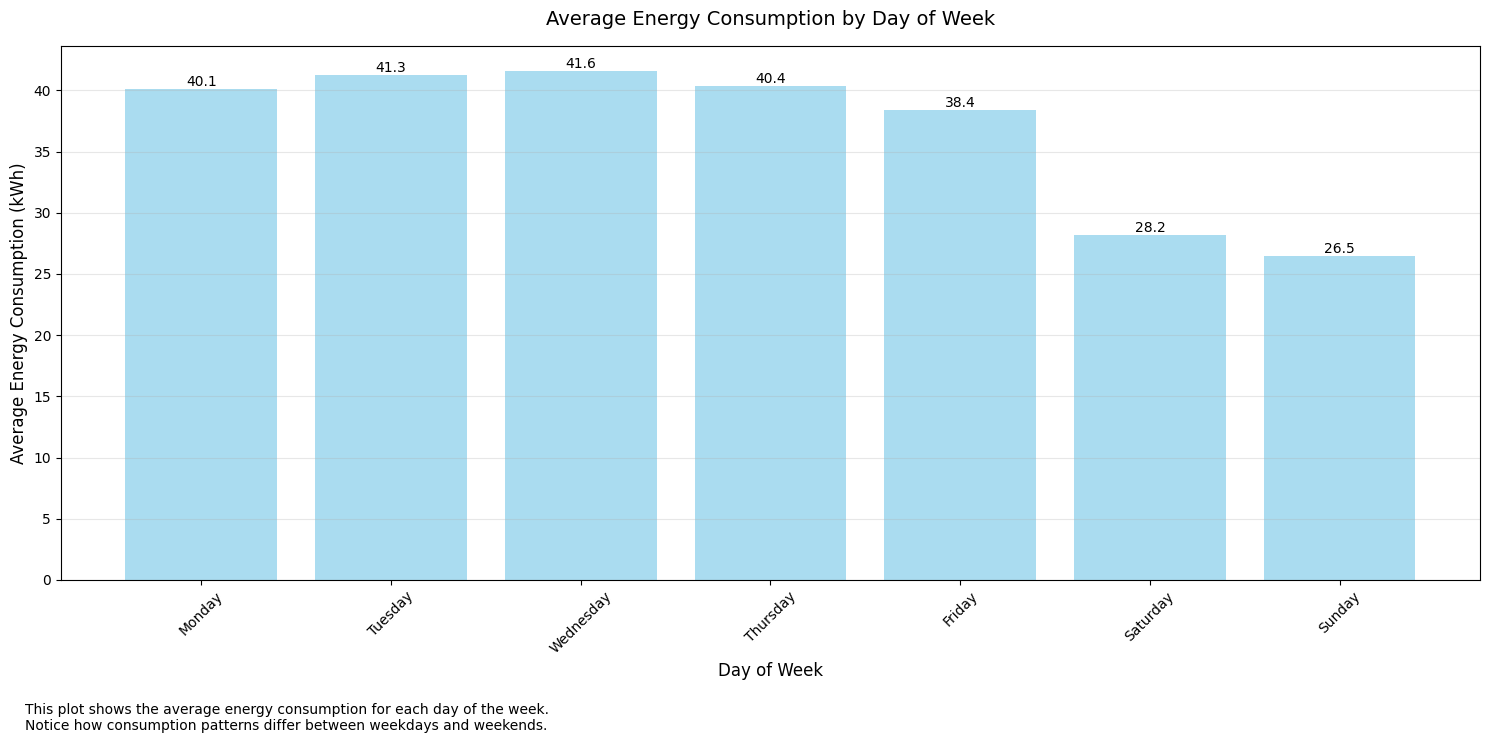

In [166]:
plt.figure(figsize=(15, 7))

daily_consumption = train_data.groupby('day_of_week')['EnergyConsumption(kWh)'].mean()

# Create bar plot
bars = plt.bar(daily_consumption.index, daily_consumption.values, 
               color='skyblue', alpha=0.7)

# Customize the plot
plt.title('Average Energy Consumption by Day of Week', fontsize=14, pad=15)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Average Energy Consumption (kWh)', fontsize=12)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',
             ha='center', va='bottom')

# Customize x-axis labels
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.xticks(range(7), days, rotation=45)

# Add grid for better readability
plt.grid(True, axis='y', alpha=0.3)

# Add a brief explanation
plt.figtext(0.02, -0.05, 
            'This plot shows the average energy consumption for each day of the week.\nNotice how consumption patterns differ between weekdays and weekends.',
            fontsize=10, ha='left')

plt.tight_layout()
plt.show()

#### 1.4.4. Mounthly Trends

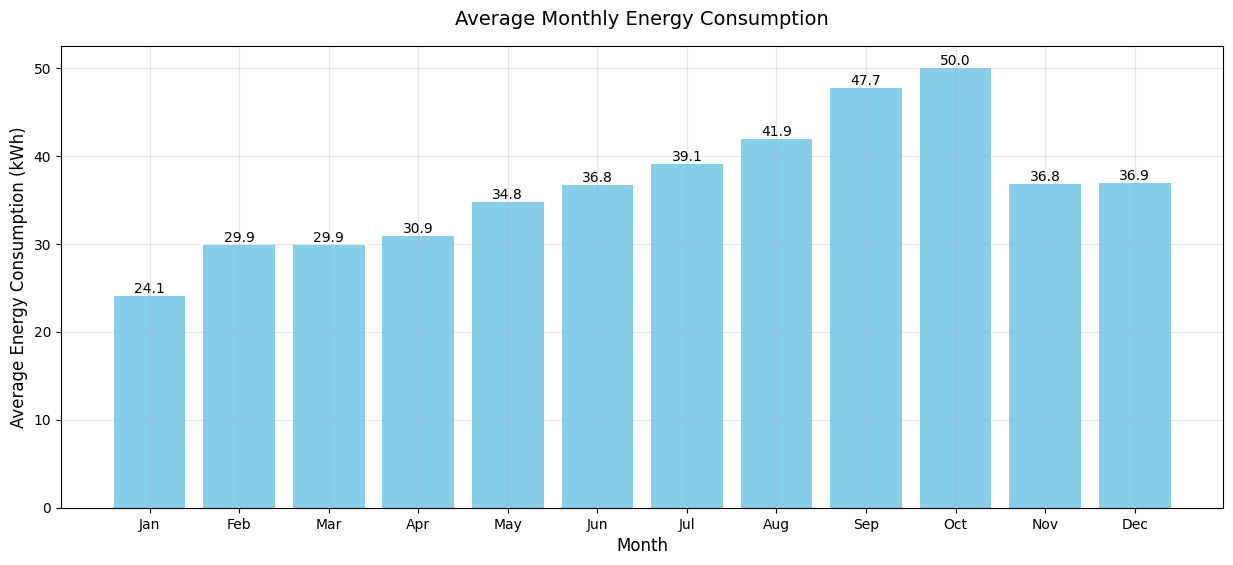

In [167]:
plt.figure(figsize=(15, 6))

# Calculate monthly averages
monthly_avg = train_data.groupby('month')['EnergyConsumption(kWh)'].mean()

# Create seasonal plot
bars = plt.bar(monthly_avg.index, monthly_avg.values, color='skyblue')
plt.title('Average Monthly Energy Consumption', fontsize=14, pad=15)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Energy Consumption (kWh)', fontsize=12)
plt.grid(True, alpha=0.3)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',
             ha='center', va='bottom')

plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

#### 1.4.5. Time Series Plot

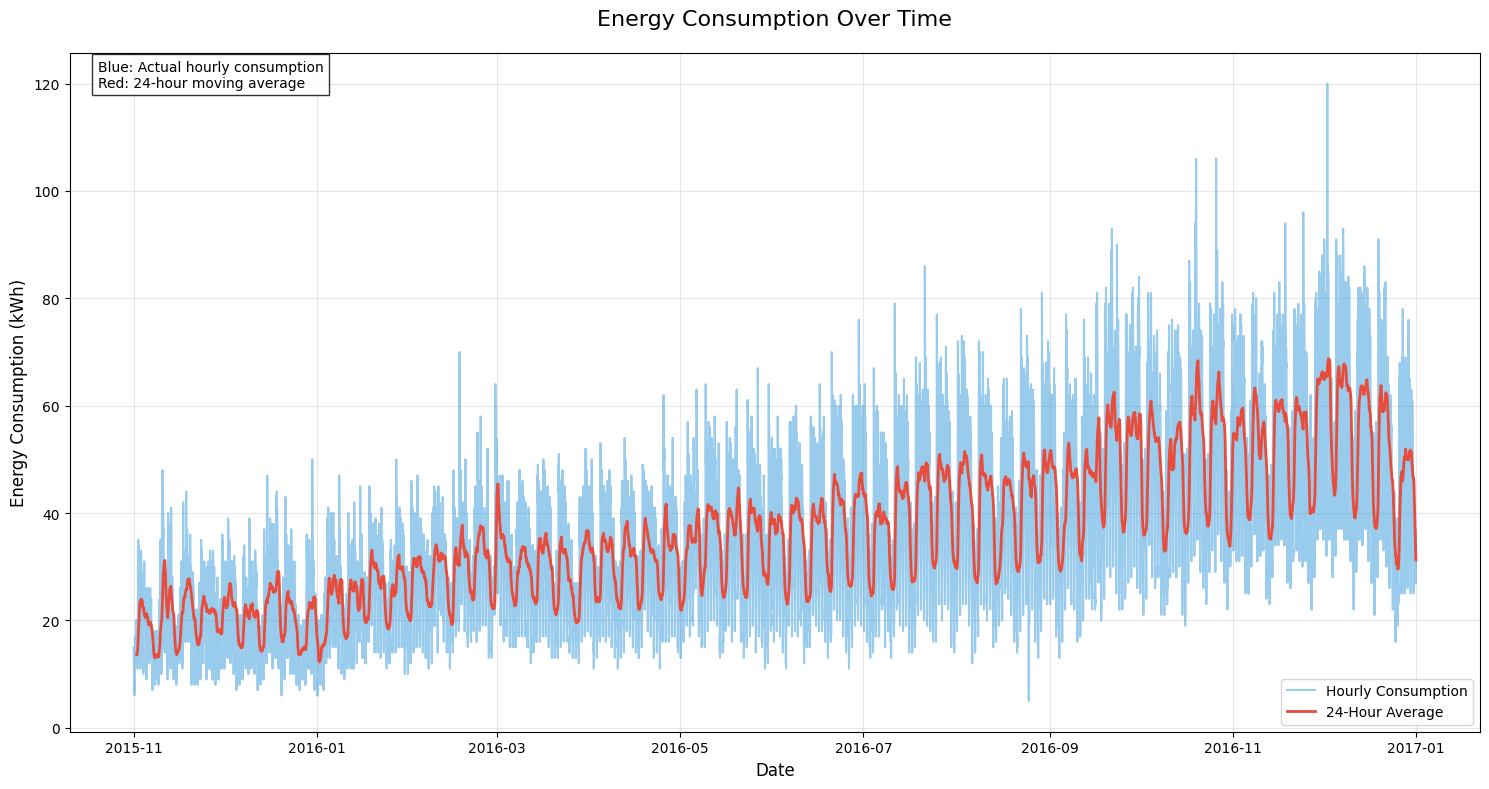

In [168]:
plt.figure(figsize=(15, 8))

plt.plot(train_data['DateTime'], train_data['EnergyConsumption(kWh)'],
         color='#3498db', alpha=0.5, label='Hourly Consumption')

# Add rolling average
window_size = 24  # 24 hours
rolling_avg = train_data['EnergyConsumption(kWh)'].rolling(window=window_size).mean()
plt.plot(train_data['DateTime'], rolling_avg,
         color='#e74c3c', linewidth=2, label='24-Hour Average')

# Customize plot
plt.title('Energy Consumption Over Time', fontsize=16, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Energy Consumption (kWh)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

# Add annotations
plt.annotate('Blue: Actual hourly consumption\nRed: 24-hour moving average',
            xy=(0.02, 0.95), xycoords='axes fraction',
            bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

### 1.5. Correlation with Target Variable
The correlation between the target variable and the feature variables is an essential aspect of feature selection.
- **Positive Correlation**: If the correlation between the target variable and a feature variable is positive,
- **Negative Correlation**: If the correlation between the target variable and a feature variable is negative,
- **No Correlation**: If the correlation between the target variable and a feature variable is zero.

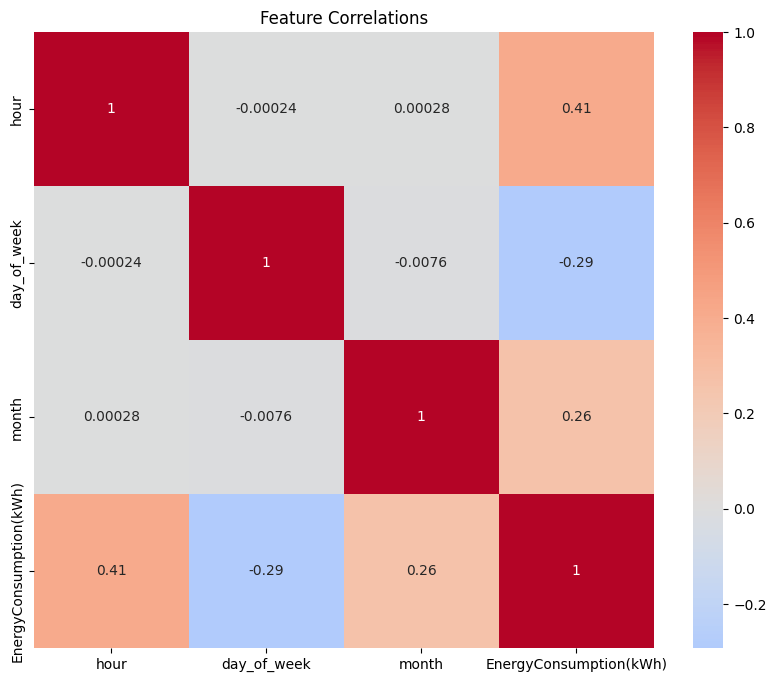

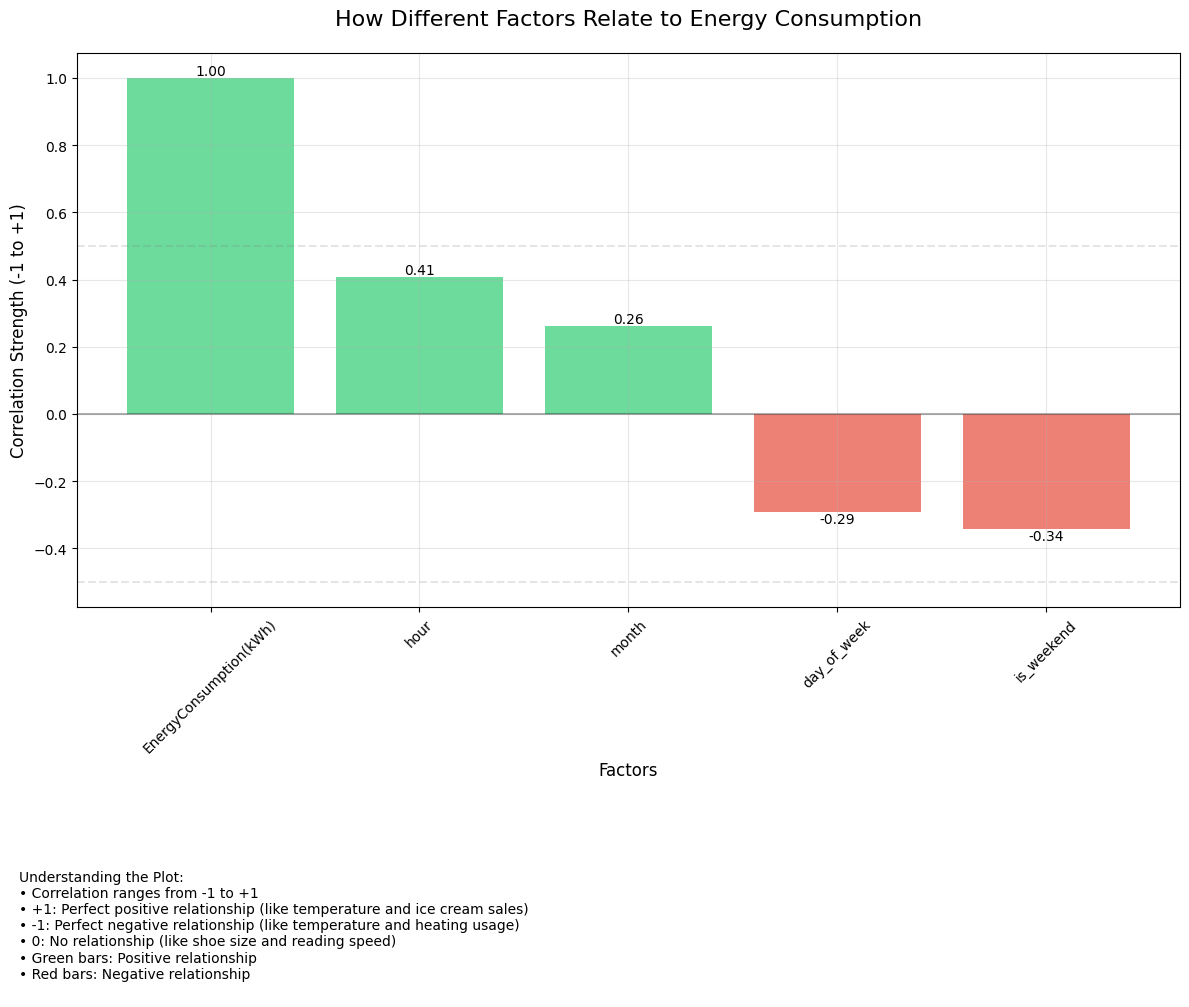


Relationship Strength Summary:
• When EnergyConsumption(kWh) goes up, energy consumption tends to increases (strong relationship: 1.00)
• When hour goes up, energy consumption tends to increases (moderate relationship: 0.41)
• When month goes up, energy consumption tends to increases (weak relationship: 0.26)
• When day_of_week goes up, energy consumption tends to decreases (weak relationship: -0.29)
• When is_weekend goes up, energy consumption tends to decreases (moderate relationship: -0.34)


In [169]:
# Cell 10: Correlation Analysis
# Calculate correlations
correlation_matrix = train_data[['hour', 'day_of_week', 'month', 'EnergyConsumption(kWh)']].corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlations')
plt.show()

# Create figure
plt.figure(figsize=(12, 8))

# Calculate correlations with target
features = ['hour', 'day_of_week', 'month', 'is_weekend', 'EnergyConsumption(kWh)']
correlation_matrix = train_data[features].corr()['EnergyConsumption(kWh)'].sort_values(ascending=False)

# Create bar plot
colors = ['#2ecc71' if x >= 0 else '#e74c3c' for x in correlation_matrix]
bars = plt.bar(range(len(correlation_matrix)), 
               correlation_matrix,
               color=colors,
               alpha=0.7)

# Customize appearance
plt.title('How Different Factors Relate to Energy Consumption', fontsize=16, pad=20)
plt.xlabel('Factors', fontsize=12)
plt.ylabel('Correlation Strength (-1 to +1)', fontsize=12)

# Add feature labels
plt.xticks(range(len(correlation_matrix)), 
           correlation_matrix.index,
           rotation=45)

# Add correlation values on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., 
             height,
             f'{height:.2f}',
             ha='center', 
             va='bottom' if height >= 0 else 'top')

# Add reference lines
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.2)
plt.axhline(y=-0.5, color='gray', linestyle='--', alpha=0.2)

# Add explanation box
explanation_text = '''
Understanding the Plot:
• Correlation ranges from -1 to +1
• +1: Perfect positive relationship (like temperature and ice cream sales)
• -1: Perfect negative relationship (like temperature and heating usage)
• 0: No relationship (like shoe size and reading speed)
• Green bars: Positive relationship
• Red bars: Negative relationship
'''

plt.figtext(0.02, -0.25, explanation_text, fontsize=10, ha='left')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print numerical interpretation
print("\nRelationship Strength Summary:")
for feature, corr in correlation_matrix.items():
    strength = "strong" if abs(corr) > 0.5 else "moderate" if abs(corr) > 0.3 else "weak"
    direction = "increases" if corr > 0 else "decreases"
    print(f"• When {feature} goes up, energy consumption tends to {direction} ({strength} relationship: {corr:.2f})")

### 1.6. Time Series Decomposition
- Time series decomposition is a technique used to break down a time series into its underlying components. This can
include trend, seasonality, and residuals. The goal of decomposition is to identify the underlying patterns and
trends in the data, which can be useful for forecasting and other applications.

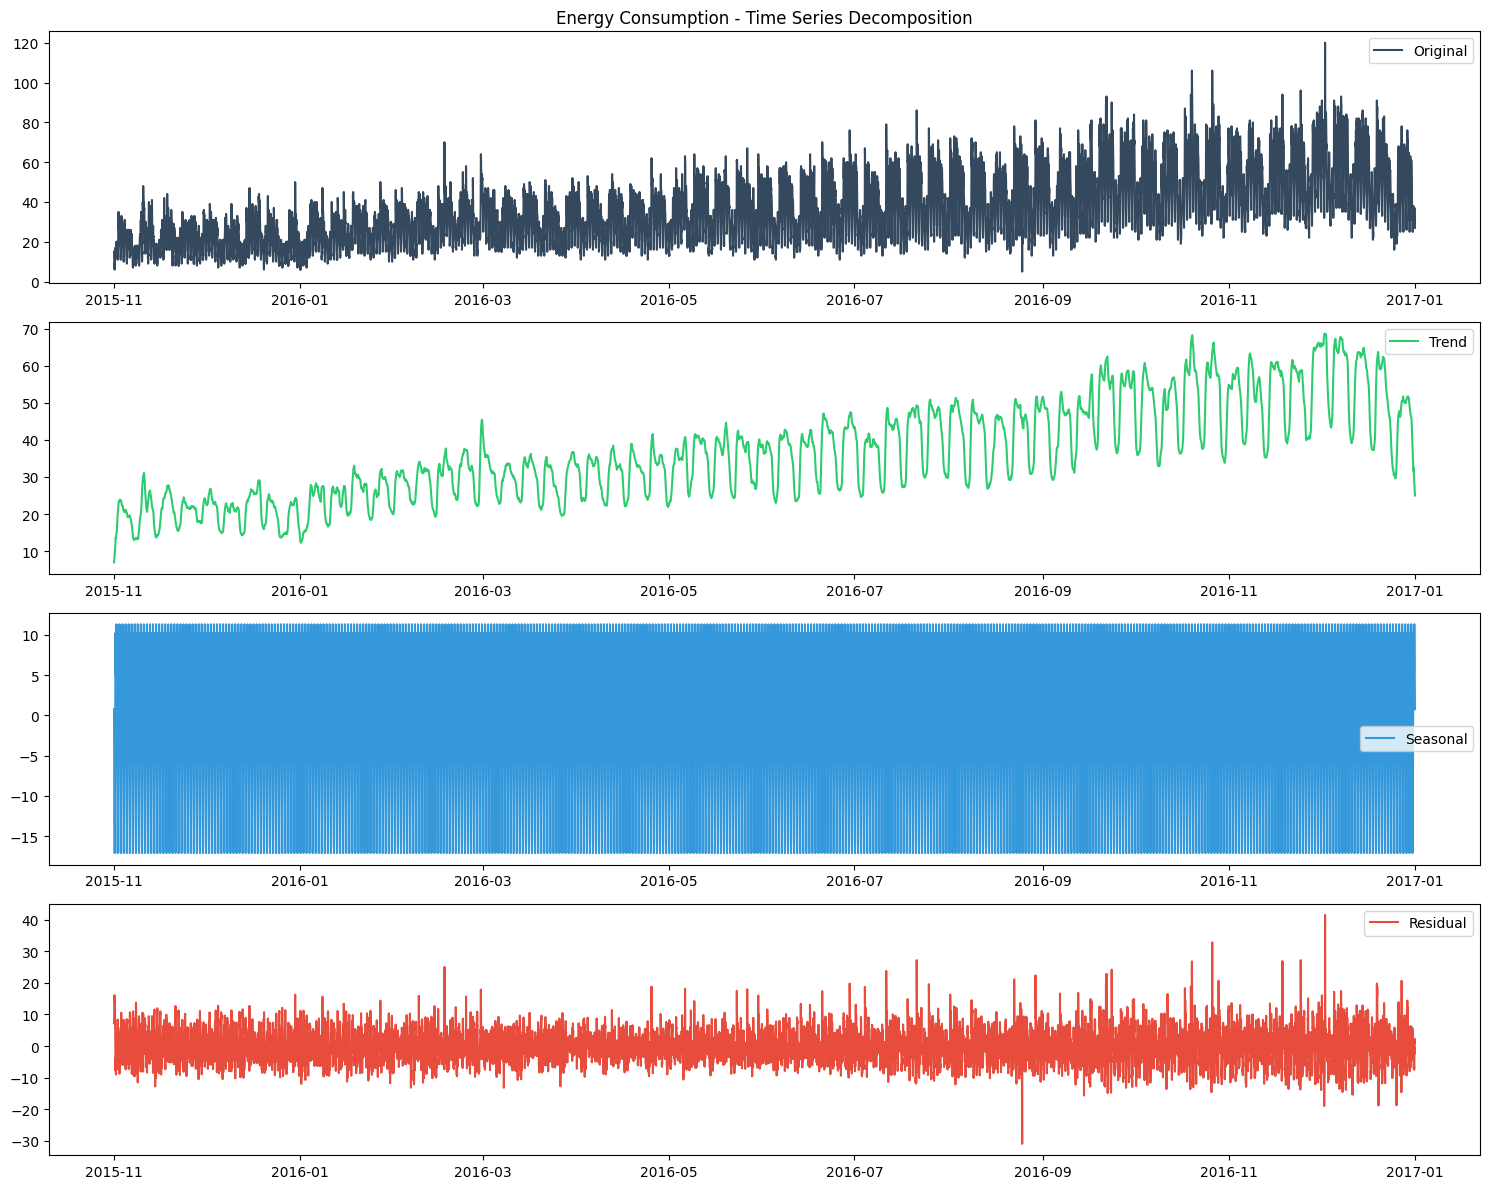

In [170]:
# Prepare time series data
ts_data = train_data.set_index('DateTime')['EnergyConsumption(kWh)']

# Decompose series
decomposition = seasonal_decompose(ts_data, 
                                 period=24,  # Daily seasonality
                                 extrapolate_trend='freq')

# Visualize components
plt.figure(figsize=(15, 12))

# Plot components
components = ['Original', 'Trend', 'Seasonal', 'Residual']
data = [ts_data, decomposition.trend, 
        decomposition.seasonal, decomposition.resid]
colors = ['#34495e', '#2ecc71', '#3498db', '#e74c3c']

for idx, (title, data, color) in enumerate(zip(components, data, colors), 1):
    plt.subplot(4, 1, idx)
    plt.plot(data, color=color, label=title)
    plt.legend()
    if idx == 1:
        plt.title('Energy Consumption - Time Series Decomposition')

plt.tight_layout()
plt.show()

## Step 2 : Data Splitting

### 2.1. Sort and Split into train and validation

In [40]:
# Sort by DateTime
train_data = train_data.sort_values(by='DateTime')

# Define split index
split_index = int(0.8 * len(train_data))

# Split into train and validation
train_df = train_data[:split_index]
val_df = train_data[split_index:]

### 2.2. Visualize Split data

/home/adel_hb/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


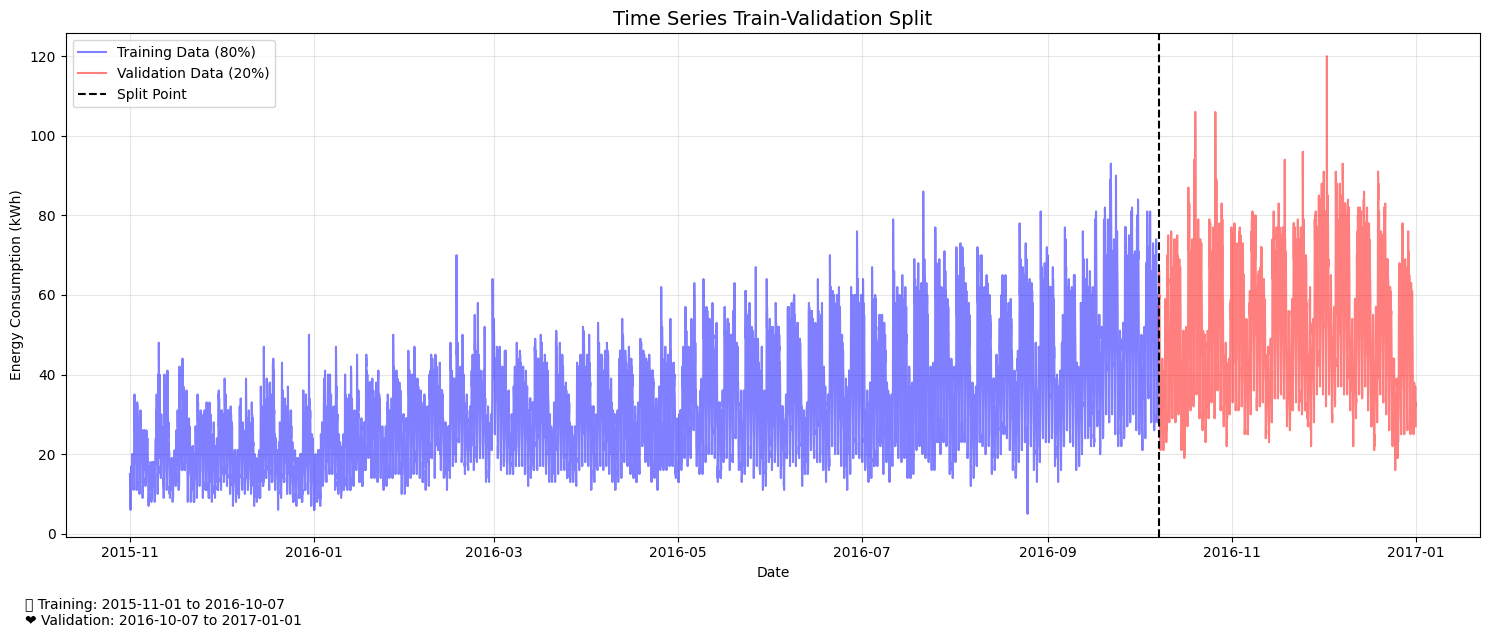

In [41]:
# Cell 2: Visualize Split
plt.figure(figsize=(15, 6))

# Plot training data
plt.plot(train_df['DateTime'], train_df['EnergyConsumption(kWh)'],
         color='blue', alpha=0.5, label='Training Data (80%)')

# Plot validation data
plt.plot(val_df['DateTime'], val_df['EnergyConsumption(kWh)'],
         color='red', alpha=0.5, label='Validation Data (20%)')

# Add split line
split_date = train_df['DateTime'].max()
plt.axvline(x=split_date, color='black', linestyle='--', label='Split Point')

# Customize plot
plt.title('Time Series Train-Validation Split', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.grid(True, alpha=0.3)

# Add explanation
plt.figtext(0.02, -0.05, 
            f'🟢 Training: {train_df["DateTime"].min().date()} to {train_df["DateTime"].max().date()}\n' +
            f'❤️ Validation: {val_df["DateTime"].min().date()} to {val_df["DateTime"].max().date()}',
            fontsize=10, ha='left')

plt.tight_layout()
plt.show()

### 2.3. Print Split Informations

In [42]:

# Cell 3: Print Split Information
print("\nTime Series Split Summary:")
print(f"Total samples: {len(train_data)}")
print(f"Training samples: {len(train_df)} ({len(train_df)/len(train_data)*100:.1f}%)")
print(f"Validation samples: {len(val_df)} ({len(val_df)/len(train_data)*100:.1f}%)")
print(f"\nTraining period: {train_df['DateTime'].min()} to {train_df['DateTime'].max()}")
print(f"Validation period: {val_df['DateTime'].min()} to {val_df['DateTime'].max()}")

print(train_df.head())
print(val_df.head())



Time Series Split Summary:
Total samples: 10249
Training samples: 8199 (80.0%)
Validation samples: 2050 (20.0%)

Training period: 2015-11-01 00:00:00 to 2016-10-07 14:00:00
Validation period: 2016-10-07 15:00:00 to 2017-01-01 00:00:00
             DateTime  EnergyConsumption(kWh)
0 2015-11-01 00:00:00                      15
1 2015-11-01 01:00:00                      13
2 2015-11-01 02:00:00                      10
3 2015-11-01 03:00:00                       7
4 2015-11-01 04:00:00                       9
                DateTime  EnergyConsumption(kWh)
8199 2016-10-07 15:00:00                      57
8200 2016-10-07 16:00:00                      55
8201 2016-10-07 17:00:00                      49
8202 2016-10-07 18:00:00                      61
8203 2016-10-07 19:00:00                      66


### 2.4. Save data to pickle

In [43]:
splits = {
    'train': train_df,
    'validation': val_df
}

# Save to pickle
import pickle
with open('timeseries_splits.pkl', 'wb') as f:
    pickle.dump(splits, f)

print("\nSplit data saved successfully!")


Split data saved successfully!


## Step 3 : Feature Engineering

In [45]:
# 2. Prepare data
def create_features(df):
    df = df.copy()
    # Time-based features
    df['hour'] = df['DateTime'].dt.hour
    df['dayofweek'] = df['DateTime'].dt.dayofweek
    df['quarter'] = df['DateTime'].dt.quarter
    df['month'] = df['DateTime'].dt.month
    df['year'] = df['DateTime'].dt.year
    df['dayofyear'] = df['DateTime'].dt.dayofyear
    df['dayofmonth'] = df['DateTime'].dt.day
    df['weekofyear'] = df['DateTime'].dt.isocalendar().week
    
    # Holiday feature
    us_holidays = holidays.US()
    df['is_holiday'] = df['DateTime'].isin(us_holidays).astype(int)
    
    return df

# Prepare features for both train and validation sets
train_features = create_features(train_df)
val_features = create_features(val_df)

# Define feature columns
feature_columns = ['hour', 'dayofweek', 'quarter', 'month', 'year', 
                  'dayofyear', 'dayofmonth', 'weekofyear', 'is_holiday']

# Prepare training and validation sets
X_train = train_features[feature_columns]
y_train = train_features['EnergyConsumption(kWh)']
X_val = val_features[feature_columns]
y_val = val_features['EnergyConsumption(kWh)']

# Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Reshape data for LSTM [samples, time steps, features]
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_scaled = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))


In [46]:
# 3. Build LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(100, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]))))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(100, return_sequences=False)))
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# 4. Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_val_scaled, y_val), 
                    callbacks=[early_stopping, reduce_lr], verbose=1)


Epoch 1/100


/home/adel_hb/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 652.3339 - val_loss: 269.8863 - learning_rate: 0.0010
Epoch 2/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 97.2952 - val_loss: 181.6643 - learning_rate: 0.0010
Epoch 3/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 91.1960 - val_loss: 166.1152 - learning_rate: 0.0010
Epoch 4/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 87.5116 - val_loss: 184.0599 - learning_rate: 0.0010
Epoch 5/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 85.3921 - val_loss: 172.1998 - learning_rate: 0.0010
Epoch 6/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 87.2091 - val_loss: 165.7406 - learning_rate: 0.0010
Epoch 7/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 87.5119 - val_loss: 153.6016 - learning_rate: 0.0010
Epoch 8/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 85.8653 - val_loss: 174.7122 - learning_rate: 0.0010
Epoch 9/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 82.5032 - val_loss: 149.4227 - learnin

In [47]:

# 5. Make predictions and evaluate
val_predictions = model.predict(X_val_scaled)
rmse = np.sqrt(mean_squared_error(y_val, val_predictions))


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


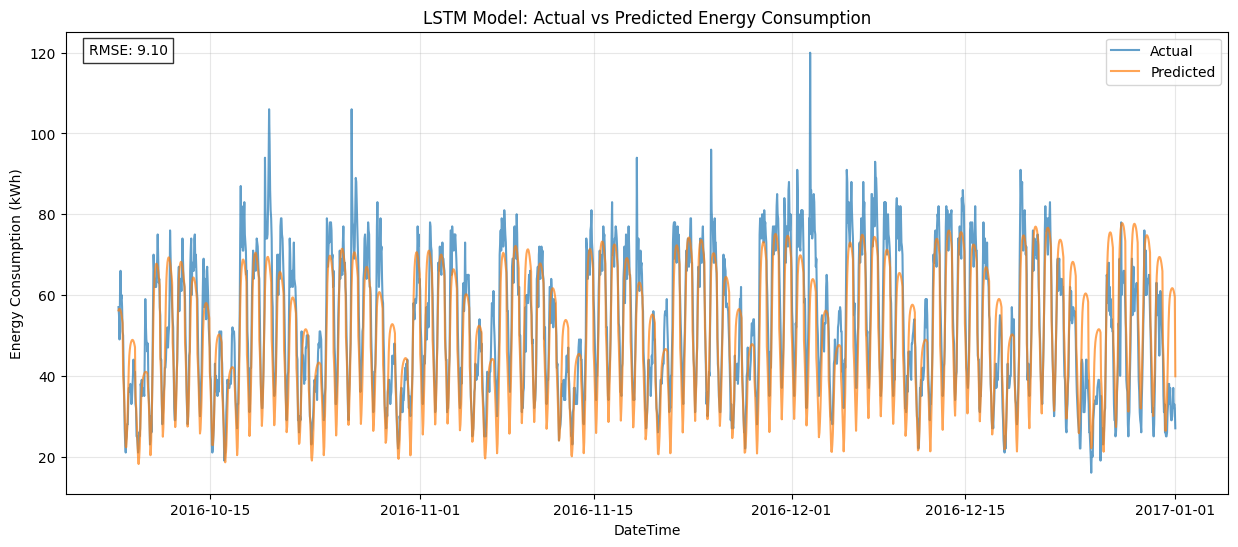


Model Performance Metrics:
RMSE: 9.10


In [48]:

# Visualize results
plt.figure(figsize=(15, 6))

# Plot actual vs predicted
plt.plot(val_features['DateTime'], y_val, label='Actual', alpha=0.7)
plt.plot(val_features['DateTime'], val_predictions, label='Predicted', alpha=0.7)
plt.title('LSTM Model: Actual vs Predicted Energy Consumption')
plt.xlabel('DateTime')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.annotate(f'RMSE: {rmse:.2f}', xy=(0.02, 0.95), xycoords='axes fraction', bbox=dict(facecolor='white', alpha=0.8))

plt.show()

print(f"\nModel Performance Metrics:")
print(f"RMSE: {rmse:.2f}")


In [335]:

# 6. Prepare test data
test_data = pd.read_csv('data/test_energy.csv')
test_data['DateTime'] = pd.to_datetime(test_data['DateTime'])

# Create features for test data
test_features = create_features(test_data)

# Ensure the same feature columns are used
X_test = test_features[feature_columns]

# Scale the test data
X_test_scaled = scaler.transform(X_test)
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Make predictions on test data
test_predictions = model.predict(X_test_scaled)

# Create submission file
submission = pd.DataFrame({
    'DateTime': test_data['DateTime'],
    'EnergyConsumption(kWh)': test_predictions.flatten()
})

submission.to_csv('lstm_submission.csv', index=False)

print("Submission file created successfully!")

136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Submission file created successfully!
